# 第1回　線形回帰
2020年3月16日（月）　石村遼汰

## 単回帰

## データセット
ボストン住宅価格データ

In [1]:
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

boston = load_boston()
# 可視化の都合で6列目だけ使用する
X = pd.DataFrame(boston.data, columns=boston.feature_names).values[:, 5]
X = X.reshape(len(X), 1)
y = boston.target

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(X, y)

## scikit-learnの線形回帰モデル

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 推定された係数

In [4]:
print(f'coef:{lr.coef_}  intercept:{lr.intercept_}')

coef:[9.10210898]  intercept:-34.67062077643857


### 回帰直線を書く

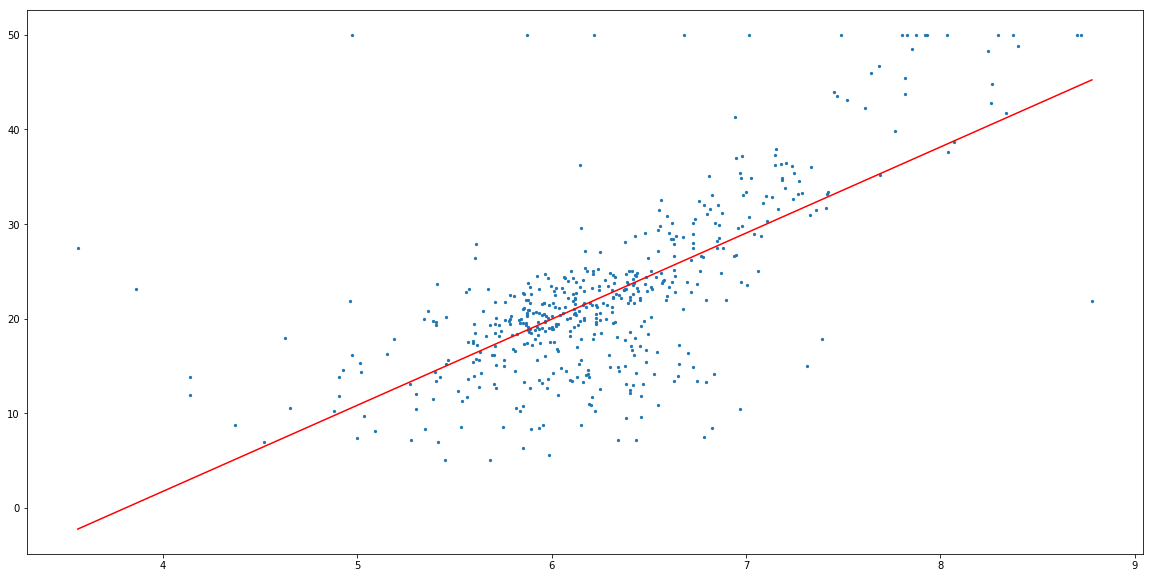

In [5]:
x_min = X.min()
x_max = X.max()
y_min = x_min * lr.coef_[0] + lr.intercept_
y_max = x_max * lr.coef_[0] + lr.intercept_

plt.figure(figsize=(20, 10))
plt.scatter(X, y, s=5)
plt.plot([x_min, x_max], [y_min, y_max], color='red')

# 自力で実装ver.

In [6]:
import numpy as np

class MyLinearRegression():
    def __init__(self, fit_intercept=True):
        self.coef_ = None
        self.intercept_ = None
        self.fit_intercept = fit_intercept
        
    def add_constant(self, X):
        return np.hstack((X, np.ones(shape=(len(X), 1))))
    
    def fit(self, X, y):
        # 定数項を追加
        if self.fit_intercept:
            X = self.add_constant(X)
        # 係数を求める
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.coef_ = w[:-1]
        self.intercept_ = w[-1]
        return
    
    def predict(self, X):
        # 定数項を追加
        if self.fit_intercept:
            X = self.add_constant(X)
        y_pred = X @ np.hstack((self.coef_, self.intercept_))
        return y_pred

In [7]:
mlr = MyLinearRegression(fit_intercept=True)
mlr.fit(X, y)

### 推定された係数

In [8]:
print(f'coef:{mlr.coef_}  intercept:{mlr.intercept_}')

coef:[9.10210898]  intercept:-34.670620776439385


In [9]:
print(f'coef:{lr.coef_}  intercept:{lr.intercept_}')

coef:[9.10210898]  intercept:-34.67062077643857


sklearnで計算したものと一致している

---

# 係数の区間推定を行う

## statsmodelにて実行

In [10]:
import statsmodels.api as sm

X = pd.DataFrame(boston.data, columns=boston.feature_names).values[:, 5]
model = sm.OLS(y, sm.add_constant(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Thu, 07 May 2020   Prob (F-statistic):           2.49e-74
Time:                        00:22:40   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.6706      2.650    -13.084      0.0

## 自力で実装

### 係数の母分散の不偏推定量を求める

In [11]:
X = pd.DataFrame(boston.data, columns=boston.feature_names).values[:, 5]
X = X.reshape(len(X), 1)
# 残差平方和
y_pred = mlr.predict(X)
ssr = (y - y_pred).T @ (y - y_pred)
ssr

22061.879196211798

In [12]:
# サンプル数と説明変数の個数。1は定数項
n, k = X.shape
degree_of_freedom = n - k - 1

# 不偏推定量　マイナス1は定数項
X = np.hstack((X, np.ones(shape=(len(X), 1))))
sigma_hat = ssr * np.linalg.inv(X.T @ X) / degree_of_freedom

In [13]:
# 係数の標準誤差　対角成分のみ抽出
se = np.diag(np.sqrt(sigma_hat))
se

array([0.41902656, 2.64980299])

### t値を求める

In [14]:
w = np.hstack((mlr.coef_, mlr.intercept_))
t_values = w / se
t_values

array([ 21.72203351, -13.08422583])

### p値を求める

In [15]:
from scipy.stats import t

p_values = np.array([])
for t_value in t_values:
    if t_value >= 0:
        p_value = (1 - t.cdf(t_value, degree_of_freedom)) * 2
    else:
        p_value = t.cdf(t_value, degree_of_freedom) * 2
    p_values = np.hstack((p_values, p_value))

### 95%信頼区間を求める

In [16]:
confidence_intervals = []

for s_i, w_i in zip(se, w):
    left = s_i * t.ppf(0.025, degree_of_freedom) + w_i
    right = s_i * t.ppf(0.975, degree_of_freedom) + w_i
    confidence_intervals.append(np.array([left, right]))
np.array(confidence_intervals)

array([[  8.27885504,   9.92536292],
       [-39.87664103, -29.46460052]])

**おおよそ一致している！**

## 係数の推定を含めた実装

In [17]:
import numpy as np
from scipy.stats import t
from IPython.core.display import display
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format


class MyLinearRegression():
    def __init__(self, fit_intercept=True):
        self.coef_ = None
        self.intercept_ = None
        self.fit_intercept = fit_intercept
        self.w = None
        
    def __add_constant(self, X):
        return np.hstack((X, np.ones(shape=(len(X), 1))))
    
    def fit(self, X, y):
        # 定数項を追加
        if self.fit_intercept:
            X = self.__add_constant(X)
        # 係数を求める
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.coef_ = self.w[:-1]
        self.intercept_ = self.w[-1]
        
        # 係数の推定を実施
        self.__calc_summary(X, y)
        return
    
    def predict(self, X):
        # 定数項を追加
        if self.fit_intercept:
            X = self.__add_constant(X)
        y_pred = X @ self.w
        return y_pred
    
    def __calc_summary(self, X, y):
        y_pred = X @ self.w
        # 残差平方和
        ssr = (y - y_pred).T @ (y - y_pred)
        # サンプル数と説明変数の個数
        n, k = X.shape
        degree_of_freedom = n - k

        # 不偏推定量
        sigma_hat = ssr * np.linalg.inv(X.T @ X) / degree_of_freedom
        
        # 係数の標準誤差　対角成分のみ抽出
        se = np.diag(np.sqrt(sigma_hat))
        
        # t値を求める
        t_values = self.w / se
        
        # p値を求める
        p_values = np.array([])
        for t_value in t_values:
            if t_value >= 0:
                p_value = (1 - t.cdf(t_value, degree_of_freedom)) * 2
            else:
                p_value = t.cdf(t_value, degree_of_freedom) * 2
            p_values = np.hstack((p_values, p_value))
            
        # 信頼区間を求める
        confidence_intervals = []
        for s_i, w_i in zip(se, self.w):
            left = s_i * t.ppf(0.025, degree_of_freedom) + w_i
            right = s_i * t.ppf(0.975, degree_of_freedom) + w_i
            confidence_intervals.append(np.array([left, right]))
        confidence_intervals = np.array(confidence_intervals)
        
        if self.fit_intercept:
            names = [f'x_{i}' for i in range(1, k)]
            names.append('const')
        else:
            names = [f'x_{i}' for i in range(1, k+1)]
        
        summary_dict = {
            'name': names
            , 'coef': self.w
            , 'std error': se
            , 't': t_values
            , 'P>|t|': p_values
            , '[0.025': confidence_intervals[:, 0]
            , '0.975]': confidence_intervals[:, 1]
        }
        self.df_summary = pd.DataFrame.from_dict(summary_dict, orient='index').T
        return
        
    def summary(self):
        display(self.df_summary)
        return

In [18]:
X = pd.DataFrame(boston.data, columns=boston.feature_names).values[:, 5]
X = X.reshape(len(X), 1)
mlr = MyLinearRegression(fit_intercept=True)
mlr.fit(X, y)

In [19]:
mlr.summary()

,name,coef,std error,t,P>|t|,[0.025,0.975]
0,x_1,9.1021,0.4190,21.7220,0.0000,8.2789,9.9254
1,const,-34.6706,2.6498,-13.0842,0.0000,-39.8766,-29.4646


In [20]:
X = pd.DataFrame(boston.data, columns=boston.feature_names).values
y = boston.target
mlr = MyLinearRegression(fit_intercept=True)
mlr.fit(X, y)
mlr.summary()

,name,coef,std error,t,P>|t|,[0.025,0.975]
0,x_1,-0.1080,0.0329,-3.2865,0.0011,-0.1726,-0.0434
1,x_2,0.0464,0.0137,3.3816,0.0008,0.0194,0.0734
2,x_3,0.0206,0.0615,0.3343,0.7383,-0.1003,0.1414
3,x_4,2.6867,0.8616,3.1184,0.0019,0.9939,4.3796
4,x_5,-17.7666,3.8197,-4.6513,0.0000,-25.2716,-10.2616
5,x_6,3.8099,0.4179,9.1161,0.0000,2.9887,4.6310
6,x_7,0.0007,0.0132,0.0524,0.9582,-0.0253,0.0266
7,x_8,-1.4756,0.1995,-7.3980,0.0000,-1.8675,-1.0837
8,x_9,0.3060,0.0663,4.6129,0.0000,0.1757,0.4364
9,x_10,-0.0123,0.0038,-3.2800,0.0011,-0.0197,-0.0049
